<a href="https://colab.research.google.com/github/MateoProjects/TFM/blob/main/Stable_diffusion_img2img_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Img2img using stable diffusion

In [1]:
#@title Instalation {display-mode: "form"} 
!pip install -qq diffusers transformers scipy ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 112 kB 4.1 MB/s 
     |████████████████████████████████| 4.7 MB 20.9 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 120 kB 91.8 MB/s 
     |████████████████████████████████| 6.6 MB 60.7 MB/s 
     |████████████████████████████████| 1.6 MB 4.2 MB/s 


In [2]:
#@title Login to HuggingFace {display-mode: "form"}
from google.colab import output
output.enable_custom_widget_manager()
from huggingface_hub import notebook_login
notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [5]:
#@title Base code {display-mode: "form"}
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import (
    AutoencoderKL,
    DDIMScheduler,
    DiffusionPipeline,
    PNDMScheduler,
    UNet2DConditionModel,
)
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

class StableDiffusionImg2ImgPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        init_image: torch.FloatTensor,
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if strength < 0 or strength > 1:
          raise ValueError(f'The value of strength should in [0.0, 1.0] but is {strength}')

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(init_image.to(self.device)).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)
        
        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)
        
        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

# Using DDIMScheduler as anexample,this also works with PNDMScheduler
# uncomment this line if you want to use it.

# scheduler = PNDMScheduler.from_config(model_path, subfolder="scheduler", use_auth_token=True)

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to("cuda")

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

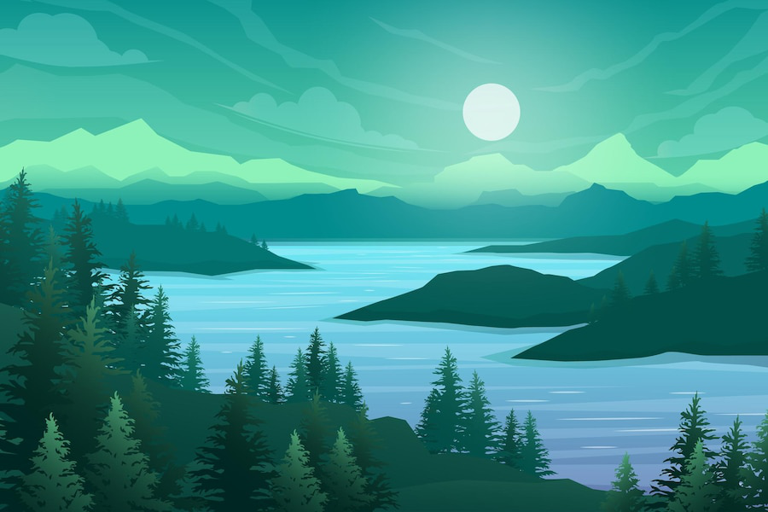

In [3]:
#@title Input image { run: "auto", display-mode: "form" }
import PIL
from PIL import Image
import numpy as np
import requests
from io import BytesIO

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.


#@markdown Insert url of image 
url = "https://img.freepik.com/free-vector/nature-scene-with-river-hills-forest-mountain-landscape-flat-cartoon-style-illustration_1150-37326.jpg?w=900&t=st=1662388972~exp=1662389572~hmac=b462299e0710f2091871e37ac84f719dbda797bc9f48ea86da6a05c34ee86ce7" #@param {type:"string"}
response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img
#@markdown **Note**: If url it's correct image will be show below. 

In [28]:
#@title Prompt for modify input image {display-mode: "form", run:"auto"}
init_image = preprocess(init_img)
prompt = " realistic landscape, trending on artstation,and a realistic moon, realistic 4k hight resolution, one bird is flying on the horizon" #@param {type:"string"}

0it [00:00, ?it/s]

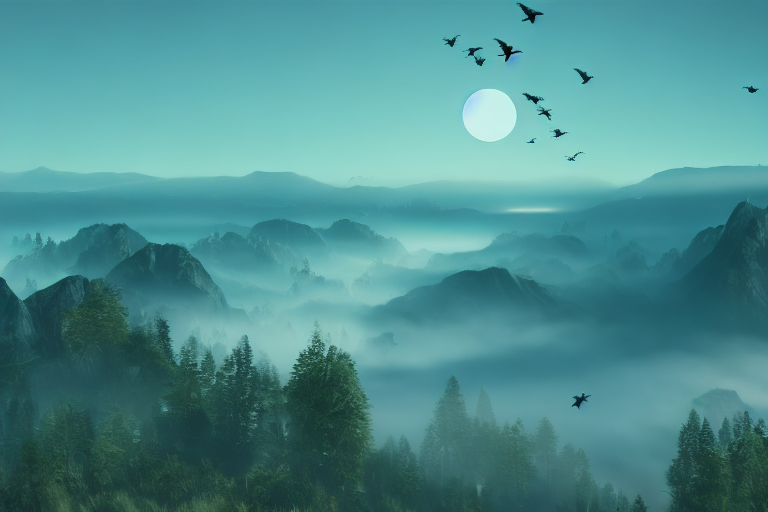

In [29]:
#@title Push play for generate image
with autocast("cuda"):
    images = pipe(prompt=prompt, init_image=init_image, strength=0.75, num_inference_steps=50, guidance_scale=7.5)["sample"]
images[0]